### Pix2Pix modeling

Model repo: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Paper: https://arxiv.org/pdf/1611.07004.pdf

In [27]:
import cv2
import glob
import os
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import statistics

from skimage import data, img_as_float, img_as_ubyte, io, color, img_as_uint
from skimage.measure import compare_ssim
from skimage.measure import compare_mse
from cellvision_lib import get_model_data_splits
# %pylab inline

In [8]:
# Proprocesing the data for pix2pix model
import os
import glob
from shutil import copyfile

MAX_DEPTH = 100
NUM_SAMPLES = 109

# folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized'
# train, test, val = train_test_val(folder_path, channels = 1, train_pp = .67, test_pp = .165, val_pp = .165, set_seed = 1)

# train[0:10]

def clear_test_files(pix2pix_path):
    print('Removing files at ' + pix2pix_path)
    outer_paths = ['A','B']
    inner_paths = ['test','train','val']
    for outer in outer_paths:
        for inner in inner_paths:
            files = glob.glob('{root}/{split}/{inner}/*'.format(root=pix2pix_path, split=outer, inner=inner))
            for f in files:
                os.remove(f)
    print('Done removing files.')
                
def setup_images_for_pix2pix(src_path, channel, num_training_images):
    print("Setting up {} training images for channel {}".format(num_training_images, channel))
    pix_folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel{}_{}'.format(channel,num_training_images)
    print("At path " + pix_folder_path)
    clear_test_files(pix_folder_path)
    train, test, val = get_model_data_splits(src_path, 
                                      channel = channel, 
                                      train_pp = .6, 
                                      test_pp = .2, 
                                      val_pp = .2, 
                                      seed = 1)

    train_images = train[0:num_training_images]
    test_images = test
    val_images = val
    print('Number of training images: ' + str(len(train_images)))
    print('Number of test images: ' + str(len(test_images)))
    print('Number of val images: ' + str(len(val_images)))
    
    def get_pix_fname(base_dir, ref_fname, _channel, mode):
        fname = os.path.basename(comp)
        end_sample_prefix_index = fname.find('_channel{}_z'.format(channel)) 
        start_z_index = end_sample_prefix_index + 11
        end_index = fname.find('.tif') 
        sample_prefix = fname[0:end_sample_prefix_index]
        z_depth = fname[start_z_index:end_index]
        new_comp_path = '{}/A/{}/{}_channel{}_z{}.jpg'.format(base_dir, mode, sample_prefix, _channel, z_depth)
        new_ref_path = '{}/B/{}/{}_channel{}_z{}.jpg'.format(base_dir, mode, sample_prefix, _channel, z_depth)
        if not os.path.exists('{}/A/{}'.format(base_dir,mode)):
            os.makedirs('{}/A/{}'.format(base_dir,mode))
        if not os.path.exists('{}/B/{}'.format(base_dir,mode)):
            os.makedirs('{}/B/{}'.format(base_dir,mode))
        return new_comp_path, new_ref_path
    
    for i, (comp, ref) in enumerate(train_images):
        new_comp_path, new_ref_path = get_pix_fname(pix_folder_path, ref, channel, "train")
        copyfile(comp, new_comp_path)
        copyfile(ref, new_ref_path)
        
    print("done with training images")
    
    for i, (comp, ref) in enumerate(test_images):
        new_comp_path, new_ref_path = get_pix_fname(pix_folder_path, ref, channel, "test")
        copyfile(comp, new_comp_path)
        copyfile(ref, new_ref_path)
        
    print("done with testing images")
        
    for i, (comp, ref) in enumerate(val_images):
        new_comp_path, new_ref_path = get_pix_fname(pix_folder_path, ref, channel, "val")
        copyfile(comp, new_comp_path)
        copyfile(ref, new_ref_path)
        
    print("done with validation images")


folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50'
# folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized'

# setup_images_for_pix2pix(folder_path, 1, 1000)
# setup_images_for_pix2pix(folder_path, 2, 1000)
# setup_images_for_pix2pix(folder_path, 3, 1000)
# setup_images_for_pix2pix(folder_path, 4, 1000)
# setup_images_for_pix2pix(folder_path, 5, 1000)

# print()
# print(glob.glob('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1/A/train/*'))
# print()
# print(glob.glob('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1/B/train/*'))


Setting up 1000 training images for channel 1
At path /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000
Removing files at /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000
Done removing files.
Number of training images: 1000
Number of test images: 1162
Number of val images: 1383
done with training images
done with testing images
done with validation images
Setting up 1000 training images for channel 2
At path /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000
Removing files at /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000
Done removing files.
Number of training images: 1000
Number of test images: 1162
Number of val images: 1383
done with training images
done with testing images
done with validation images
Setting up 1000 training images for channel 3
At path /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_1000
Removing files at /gpfs/data/lionnetlab/cellvision/pilotda

In [ ]:
"""
Commands to run with the pix2pix framework

python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/testing/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/testing/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/testing --num_imgs 200

python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000 --num_imgs 1000

bsub -Is -o fold_1_100.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100 --num_imgs 100



bsub -o log_fold_1_1000.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000
bsub -o log_fold_2_1000.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000
bsub -o log_fold_3_1000.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_1000
bsub -o log_fold_4_1000.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_1000
bsub -o log_fold_5_1000.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_1000


bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log_channel1_1000_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000 --name cellvision_channel1_1000 --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log_channel2_1000_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000 --name cellvision_channel2_1000 --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log_channel3_1000_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_1000 --name cellvision_channel3_1000 --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log_channel4_1000_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_1000 --name cellvision_channel4_1000 --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log_channel5_1000_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_1000 --name cellvision_channel5_1000 --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512


bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log_channel1_500_plat_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_500 --name cellvision_channel1_500_plat --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512 --lr_policy plateau
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log_channel1_500_step_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_500 --name cellvision_channel1_500_step --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512 --lr_policy step
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log_channel1_500_cosine_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_500 --name cellvision_channel1_500_cosine --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512 --lr_policy cosine

bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log_channel1_500_128_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_500 --name cellvision_channel1_500_128 --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512 --ngf 128 --ndf 128
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log_channel1_500_32_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_500 --name cellvision_channel1_500_32 --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512 --ngf 32 --ndf 32


bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log_channel1_500_final_jobout.txt python train.py --save_epoch_freq 5 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_500 --name cellvision_channel1_500_final --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512


bsub -Is -gpu "num=1:mode=exclusive_process:mps=yes" python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_500 --name cellvision_channel1_500 --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512

bsub -Is -gpu "num=1:mode=exclusive_process:mps=yes" python train.py --save_epoch_freq 5 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_500 --name cellvision_channel1_500_final --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512


bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o channel2_100_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_100 --name cellvision_channel2_100 --model pix2pix --direction AtoB --gpu 0 --display_id 0 --resize_or_crop none

bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o channeltesting2_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000 --name cellvision_testing2 --model pix2pix --direction AtoB --gpu 0 --display_id 0


bsub -Is -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100 --name cellvision_channeltest --model pix2pix --direction AtoB --num_test 10000 --phase val --loadSize 512 --fineSize 512


bsub -o val1_1000.txt -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000 --name cellvision_channel1_1000 --model pix2pix --direction AtoB --num_test 10000 --phase val --loadSize 512 --fineSize 512
bsub -o val2_1000.txt -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000 --name cellvision_channel2_1000 --model pix2pix --direction AtoB --num_test 10000 --phase val --loadSize 512 --fineSize 512
bsub -o val4_1000.txt -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_1000 --name cellvision_channel4_1000 --model pix2pix --direction AtoB --num_test 10000 --phase val --loadSize 512 --fineSize 512
bsub -o val5_1000.txt -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_1000 --name cellvision_channel5_1000 --model pix2pix --direction AtoB --num_test 10000 --phase val --loadSize 512 --fineSize 512

bsub -o val5_1000.txt -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_500 --name cellvision_channel1_500 --model pix2pix --direction AtoB --num_test 10000 --phase test --loadSize 512 --fineSize 512


"""

In [72]:
from time import time

def get_ssim_mse_for_pix2pix_channel(result_path, channel, sample_size):
    print("\nGetting MSE and SSIM for sample size {} and channel {}:\n".format(sample_size, channel))
    start = time()
    result_dir = '{}/cellvision_channel{}_{}/val_latest/images'.format(result_path, channel, sample_size)
    real_path_low = '{}/*_real_A.png'.format(result_dir)
    real_low_imgs = glob.glob(real_path_low)
    print("    Loading {} images".format(len(real_low_imgs)))
    channel_mse = []
    channel_ssim = []
    for real_path_low in real_low_imgs:
        fname = os.path.basename(real_path_low)
        fname_prefix = fname[:-11]
        real_path_high = '{}/{}_real_B.png'.format(result_dir, fname_prefix)
        fake_path = '{}/{}_fake_B.png'.format(result_dir, fname_prefix)
        try:
            real_img_high2 = cv2.imread(real_path_high, cv2.IMREAD_GRAYSCALE)
            fake_img2 = cv2.imread(fake_path, cv2.IMREAD_GRAYSCALE)
        except OSError:
            print("OSERROR skipping " + fake_path)

        fake_high_ssim = compare_ssim(fake_img2, real_img_high2)
        channel_ssim.append( fake_high_ssim )

        fake_high_mse = compare_mse(fake_img2, real_img_high2)
        channel_mse.append( fake_high_mse )
    print('    mean ssim: ' + str(statistics.mean(channel_ssim)))
    print('    mean mse: ' + str(statistics.mean(channel_mse)))
    end = time()
    print("    Elapsed time: {} seconds".format(round(end - start, 2)))
    return channel_ssim, channel_mse


channels = list(range(1,6))
sample_sizes =[100, 500, 1000]

# channels = [1]
# sample_sizes =[100]

results_path = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results'

results_dirs = []
mses = []
ssims = []
for sample_size in sample_sizes:
    sub_results = []
    mses_sub = []
    ssim_sub = []
    for channel in channels:
        channel_ssim, channel_mse = get_ssim_mse_for_pix2pix_channel(results_path, channel, sample_size)
        mses_sub.append(channel_mse)
        ssim_sub.append(channel_ssim)
        print('Writing the results for sample size {} and channel {}'.format(sample_size, channel))
        write_path = 'sum_stats_channel{}_size{}'.format(channel, sample_size)
        pkl.dump(channel_ssim, open('ssim_' + write_path, "wb"))
        pkl.dump(channel_mse, open('mse_' + write_path, "wb"))

    mses.append(mses_sub)
    ssims.append(ssim_sub)

# print(len(mses[0][0][0]))
# results_dir = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision5/test_latest/images'

# out_imgs = glob.glob(results_dir)

# When you do the comp for sample97_channel1_z20, it should be around 0.32277106825144203 -> .33



Getting MSE and SSIM for sample size 100 and channel 1:

    Loading 1383 images
    mean ssim: 0.9198161140000813
    mean mse: 12.136627721338279
    Elapsed time: 87.8 seconds
Writing the results for sample size 100 and channel 1

Getting MSE and SSIM for sample size 100 and channel 2:

    Loading 1383 images
    mean ssim: 0.9239312548306321
    mean mse: 8.099485848317178
    Elapsed time: 97.66 seconds
Writing the results for sample size 100 and channel 2

Getting MSE and SSIM for sample size 100 and channel 3:

    Loading 1383 images
    mean ssim: 0.9463040299308249
    mean mse: 2.7833766951047245
    Elapsed time: 94.31 seconds
Writing the results for sample size 100 and channel 3

Getting MSE and SSIM for sample size 100 and channel 4:

    Loading 1383 images
    mean ssim: 0.9514912285437691
    mean mse: 2.227907218022874
    Elapsed time: 97.89 seconds
Writing the results for sample size 100 and channel 4

Getting MSE and SSIM for sample size 100 and channel 5:

    L

In [78]:
out_path = '/home/dg3047/capstone/CellVision/notebooks'

channels = list(range(1,6))
sample_sizes =[100, 500, 1000]

results_dirs = []
ssim_means = []
ssim_stds = []
for sample_size in sample_sizes:
    for channel in channels:
        ssim_path = '{}/ssim_sum_stats_channel{}_size{}'.format(out_path,channel, sample_size)
        with open(ssim_path, 'rb') as pickle_file:
            channel_ssim = pkl.load(pickle_file)
            ssim_std = statistics.stdev(channel_ssim)
            ssim_mean = statistics.mean(channel_ssim)
            ssim_means.append(ssim_mean)
            ssim_stds.append(ssim_std)

mse_means = []
mse_stds = []
for sample_size in sample_sizes:
    for channel in channels:
        mse_path = '{}/mse_sum_stats_channel{}_size{}'.format(out_path,channel, sample_size)
        with open(mse_path, 'rb') as pickle_file:
            channel_mse = pkl.load(pickle_file)
            mse_std = statistics.stdev(channel_mse)
            mse_mean = statistics.mean(channel_mse)
            mse_means.append(mse_mean)
            mse_stds.append(mse_std)

In [81]:
print(len(mse_means))
mse_means[0]

15


12.136627721338279

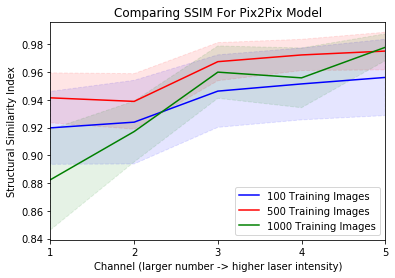

In [90]:
# Comparing SSIM
import operator
from numpy import array
ssim_means = array(ssim_means)
ssim_stds = array(ssim_stds)

plt.plot(list(range(1, 6)), ssim_means[0:5], label="100 Training Images", color='blue') 
plt.plot(list(range(1, 6)), ssim_means[5:10], label="500 Training Images", color='red') 
plt.plot(list(range(1, 6)), ssim_means[10:15], label="1000 Training Images", color='green') 

plt.fill_between(list(range(1, 6)), ssim_means[0:5] + ssim_stds[0:5], np.subtract(ssim_means[0:5],ssim_stds[0:5]), 
                 color="blue", linestyle="--", alpha=0.1)

plt.fill_between(list(range(1, 6)), ssim_means[5:10] + ssim_stds[5:10], np.subtract(ssim_means[5:10],ssim_stds[5:10]), 
                 color="red", linestyle="--", alpha=0.1)

plt.fill_between(list(range(1, 6)), ssim_means[10:15] + ssim_stds[10:15], np.subtract(ssim_means[10:15],ssim_stds[10:15]), 
                 color="green", linestyle="--", alpha=0.1)

plt.title('Comparing SSIM For Pix2Pix Model')
plt.legend(loc = 'lower right')
# plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('Structural Similarity Index')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

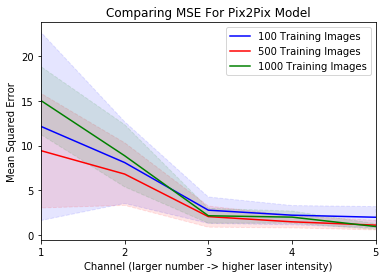

In [91]:
# Comparing MSE
import operator
from numpy import array
mse_means = array(mse_means)
mse_stds = array(mse_stds)

plt.plot(list(range(1, 6)), mse_means[0:5], label="100 Training Images", color='blue') 
plt.plot(list(range(1, 6)), mse_means[5:10], label="500 Training Images", color='red') 
plt.plot(list(range(1, 6)), mse_means[10:15], label="1000 Training Images", color='green') 

plt.fill_between(list(range(1, 6)), mse_means[0:5] + mse_stds[0:5], np.subtract(mse_means[0:5],mse_stds[0:5]), 
                 color="blue", linestyle="--", alpha=0.1)

plt.fill_between(list(range(1, 6)), mse_means[5:10] + mse_stds[5:10], np.subtract(mse_means[5:10],mse_stds[5:10]), 
                 color="red", linestyle="--", alpha=0.1)

plt.fill_between(list(range(1, 6)), mse_means[10:15] + mse_stds[10:15], np.subtract(mse_means[10:15],mse_stds[10:15]), 
                 color="green", linestyle="--", alpha=0.1)

plt.title('Comparing MSE For Pix2Pix Model')
plt.legend(loc = 'upper right')
# plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('Mean Squared Error')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

In [37]:
import statistics

low_means = []
fake_means = []
for channel_sample in ssims:
#         low = [ssim[0] for ssim in channel]
#         print(len(low))
#         low_std = statistics.stdev(channel)
#         low_mean = statistics.mean(channel)
#         print(low_mean)
#         low_means.append(low_mean)

#         fake = [ssim[1] for ssim in channel]
#     print(channel_sample[0:10])
    fake_std = statistics.stdev(channel_sample)
    fake_mean = statistics.mean(channel_sample)
    fake_means.append(fake_mean)


# print("Low ssim mean {} with std {}".format(low_mean,low_std))
print("Fake ssim mean {} with std {}".format(fake_mean,fake_std))
fake_means
# low_mse = [mse[0] for mse in mses]
# low_std_mse = statistics.stdev(low_mse)
# low_mean_mse = statistics.mean(low_mse)

# fake_mse = [mse[1] for mse in mses]
# fake_std_mse = statistics.stdev(fake_mse)
# fake_mean_mse = statistics.mean(fake_mse)
# print()
# print("Low mse mean {} with std {}".format(low_mean_mse,low_std_mse))
# print("Fake mse mean {} with std {}".format(fake_mean_mse,fake_std_mse))


Fake ssim mean 0.6211830519205964 with std 0.15766266139623752


[0.5386295756820442,
 0.5562004185764099,
 0.574890153184329,
 0.5880863590147779,
 0.6629885282558848,
 0.5695146221018274,
 0.5626783891434415,
 0.6023768805273643,
 0.6017421055122221,
 0.6253222128567886,
 0.4856655140266587,
 0.5364975933261948,
 0.5846174798905819,
 0.5138395790886391,
 0.6211830519205964]

In [9]:
low_means

[0.02486735948582183,
 0.03883570519013288,
 0.4334226671518876,
 0.6786831404674616,
 0.7277165273952351]

In [10]:
fake_means

[0.542089543287763,
 0.5592069445590415,
 0.6252987301860703,
 0.663344139307484,
 0.7048083727723172]

/gpfs/share/skynet/apps/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


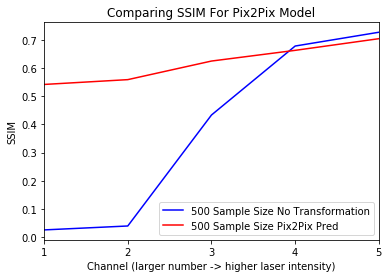

In [11]:
# Comparing MSE for denoising
plt.plot(list(range(1, 6)), low_means[0:5], label="500 Sample Size No Transformation", color='blue') 
plt.plot(list(range(1, 6)), fake_means[0:5], label="500 Sample Size Pix2Pix Pred", color='red') 
# plt.plot(list(range(1, 6)), low_means[5:10], label="1000 Sample Size No Transformation", color='purple') 
# plt.plot(list(range(1, 6)), fake_means[5:10], label="1000 Sample Size Prediction", color='green') 

plt.title('Comparing SSIM For Pix2Pix Model')
plt.legend(loc = 'lower right')
# plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('SSIM')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

In [ ]:
# Showing images
from skimage import exposure
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_real_A.png'
imsk_A = io.imread(path_to_data)
imsk_A = exposure.rescale_intensity(imsk_A,in_range=(0,np.max(imsk_A)))
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_real_B.png'
imsk_B = io.imread(path_to_data)
imsk_B = exposure.rescale_intensity(imsk_B,in_range=(0,np.max(imsk_B)))
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_fake_B.png'
fake = io.imread(path_to_data)
fake = exposure.rescale_intensity(fake,in_range=(0,np.max(fake)))
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(imsk_A);
ax[0].axis('off')
ax[1].imshow(imsk_B);
ax[1].axis('off')
ax[2].imshow(fake);
ax[2].axis('off')
plt.show()

In [ ]:
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_real_A.png'
imsk_A = io.imread(path_to_data)
imsk_A = exposure.rescale_intensity(imsk_A,in_range=(0,np.max(imsk_A)))
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_real_B.png'
imsk_B = io.imread(path_to_data)
imsk_B = exposure.rescale_intensity(imsk_B,in_range=(0,np.max(imsk_B)))
path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000/test/sample61_channel1_z48.jpg'
fake = io.imread(path_to_data)
fake = exposure.rescale_intensity(fake,in_range=(0,np.max(fake)))
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(imsk_A);
ax[0].axis('off')
ax[1].imshow(imsk_B);
ax[1].axis('off')
ax[2].imshow(fake);
ax[2].axis('off')
plt.show()

(512, 512)
(512, 512)
(512, 512, 3)
(512, 512)


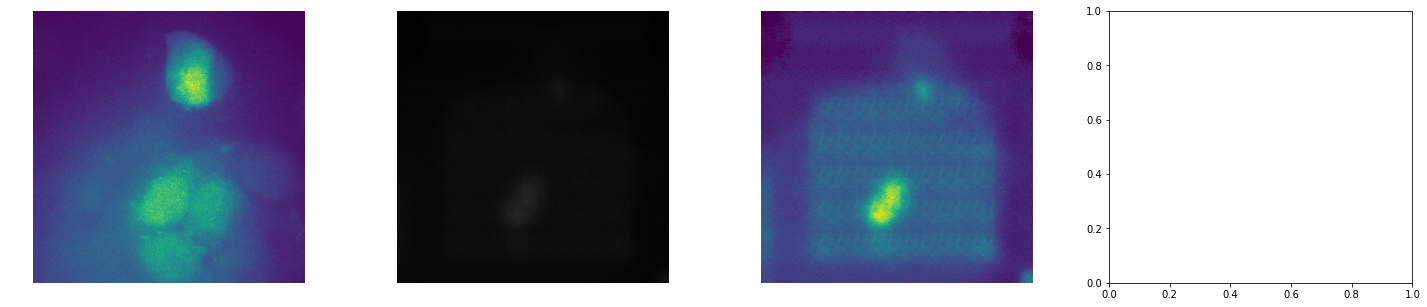

In [71]:
import cv2

path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample114_channel6_z10.tif'
skimage_original = io.imread(path_to_data).astype(np.uint)
print(skimage_original.shape)
cv_original = cv2.imread(path_to_data, cv2.COLOR_BGR2GRAY)
print(cv_original.shape)

# path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100/val/sample114_channel1_z10.jpg'
# path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample114_channel6_z10.tif'
# fold_out = io.imread(path_to_data)
# print(fold_out.shape)
# cv_fold = cv2.imread(path_to_data, cv2.COLOR_BGR2GRAY)
# print(cv_fold.shape)

path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/val_latest/images/sample114_channel1_z10_fake_B.png'
result_io = io.imread(path_to_data)
print(result_io.shape)
im_A = cv2.imread(path_to_data)
result_io_sk = cv2.imread(path_to_data, cv2.IMREAD_GRAYSCALE)
print(result_io_sk.shape)

# print(imsk_B.shape)
# print(im_A.shape)

# fake = exposure.rescale_intensity(fake,in_range=(0,np.max(fake)))
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(skimage_original);
ax[0].axis('off')
ax[1].imshow(result_io);
ax[1].axis('off')
ax[2].imshow(result_io_sk);
ax[2].axis('off')
# ax[3].imshow(cv_fold);
# ax[3].axis('off')
plt.show()


# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(25,5))
# ax.imshow(skimage_original);
# ax.axis('off')
# plt.show()

# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(25,5))
# ax.imshow(fold_out);
# ax.axis('off')
# plt.show()

# low_high_ssim = compare_ssim(skimage_original, result_io_sk)
# low_high_ssim

In [67]:
# from skimage import data, img_as_float, img_as_ubyte, io, img_as_int, img_as_uint
print(skimage_original.shape)
print(result_io_sk.shape)

print(skimage_original)
print(result_io_sk)
print(img_as_uint(skimage_original))
print(img_as_uint(result_io_sk))
low_high_ssim = compare_ssim(img_as_uint(result_io_sk), img_as_uint(skimage_original))
low_high_ssim

(512, 512)
(512, 512)
[[ 361  349  393 ...  355  354  281]
 [ 366  390  309 ...  413  331  361]
 [ 414  405  374 ...  320  305  369]
 ...
 [1521 1682 1757 ...  767  860  648]
 [1727 1730 1681 ...  810  918  845]
 [1759 1620 1600 ...  782  772  721]]
[[ 0  0  0 ...  0  0  0]
 [ 2  1  1 ...  0  0  0]
 [ 0  0  1 ...  3  0  0]
 ...
 [13  6  8 ...  2  4  2]
 [ 3  9  5 ...  1  5  3]
 [12  9  4 ...  4  2  4]]
[[ 361  349  393 ...  355  354  281]
 [ 366  390  309 ...  413  331  361]
 [ 414  405  374 ...  320  305  369]
 ...
 [1521 1682 1757 ...  767  860  648]
 [1727 1730 1681 ...  810  918  845]
 [1759 1620 1600 ...  782  772  721]]
[[   0    0    0 ...    0    0    0]
 [ 514  257  257 ...    0    0    0]
 [   0    0  257 ...  771    0    0]
 ...
 [3341 1542 2056 ...  514 1028  514]
 [ 771 2313 1285 ...  257 1285  771]
 [3084 2313 1028 ... 1028  514 1028]]


0.922034982723112

In [6]:
import cv2

path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel3_100/val_latest/images/sample114_channel3_z10_real_B.png'
skimage = io.imread(path_to_data).astype(np.uint)
print(skimage.shape)

cv_image = cv2.imread(path_to_data, cv2.IMREAD_GRAYSCALE)
print(cv_image.shape)
# flow_img = cv2.cvtColor(im_A, cv2.COLOR_RGB2BGR)
# RGB_img = cv2.cvtColor(im_A, cv2.COLOR_BGR2RGB)

path_to_data_B = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample114_channel6_z10.tif'
skimage_original = io.imread(path_to_data_B).astype(np.uint)
# imsk_B = io.imread(path_to_data_B)
print(skimage_original.shape)

_min = cv_image.min()
_max = cv_image.max()

low_high_ssim = compare_ssim(skimage_original, img_as_uint(cv_image))
low_high_ssim

(512, 512, 3)
(512, 512)
(512, 512)


1.0